In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 120 kB 63.7 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 


In [ ]:
!id="1fdWdDm8LYw68kIZ6Z7xlT3Re8QqtLWis"; conf=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$id -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p'); wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$conf&id=$id" -O mmcovid_en.csv && rm -rf /tmp/cookies.txt

--2022-08-28 20:57:54--  https://docs.google.com/uc?export=download&confirm=&id=1fdWdDm8LYw68kIZ6Z7xlT3Re8QqtLWis
Resolving docs.google.com (docs.google.com)... 172.217.214.100, 172.217.214.139, 172.217.214.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-34-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n9skalkne3772hpjen8gda5hqtj92qql/1661720250000/05536367513713019519/*/1fdWdDm8LYw68kIZ6Z7xlT3Re8QqtLWis?e=download&uuid=1b824da5-dd8f-49cd-915f-6df3e3e10219 [following]
--2022-08-28 20:57:55--  https://doc-0o-34-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n9skalkne3772hpjen8gda5hqtj92qql/1661720250000/05536367513713019519/*/1fdWdDm8LYw68kIZ6Z7xlT3Re8QqtLWis?e=download&uuid=1b824da5-dd8f-49cd-915f-6df3e3e10219
Resolving doc-0o-34-docs.googleusercontent.com (doc-0o-34-docs.googleusercontent.com)... 142.250.136.1

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold

data = pd.read_csv("mmcovid_en.csv",sep=",")
print("labels\n",data["label"].value_counts())
print("shape  \n",data.shape)

bootstrap_size = 0

if bootstrap_size != 0:
    bootstrap_factor = bootstrap_size / data.shape[0]
    bootstrap = np.random.uniform(size=data.shape[0]) < bootstrap_factor
    data = data.iloc[bootstrap]

    
X, y = data["text"].astype(str).values, data["label"].values

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
foldids = []
for fold_idx, (train, test) in tqdm(enumerate(rskf.split(X, y)), total=rskf.get_n_splits()):
    foldids.append((fold_idx,train,test))
    
print("shapes X",X.shape,"y", y.shape)

labels
 0    5304
1    2028
Name: label, dtype: int64
shape  
 (7332, 4)


100%|██████████| 10/10 [00:00<00:00, 941.14it/s]

shapes X (7332,) y (7332,)


In [ ]:
import transformers
transformers.logging.set_verbosity_error()
from torch.utils.data import DataLoader 

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import TFDistilBertModel, DistilBertTokenizerFast

from sklearn.base import BaseEstimator, TransformerMixin
import torch
import numpy as np

from scipy.sparse import csr_matrix
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("using device:", device)

if "disilbert_model" not in locals():
    disilbert_tokenizer =  AutoTokenizer.from_pretrained("distilbert-base-uncased")
    disilbert_model = AutoModel.from_pretrained("distilbert-base-uncased")
    handle = disilbert_model.to(device)


class BERTEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer =  disilbert_tokenizer
        self.model = disilbert_tokenizer
        self.max_length = 256
        self.model_name = disilbert_model

    def fit(self, X=None, y=None):
        pass
    
    def encode(self, txt):
        return self.tokenizer(txt, max_length=self.max_length, 
                              truncation=True, padding=True, return_tensors="pt")

    def transform(self, X=None):
        dataloader = DataLoader(X, batch_size=4, shuffle=False)
        allembeds = []
        for batch in tqdm(dataloader):
            batchenc = disilbert_tokenizer(batch, max_length=256, truncation=True, padding=True, return_tensors="pt")
            input_ids = batchenc['input_ids'].to(device)
            attention_mask = batchenc['attention_mask'].to(device)
            batchout = disilbert_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            embeds = [vec[0].cpu().detach().numpy() for vec in batchout[1][-1]]
            allembeds.extend(embeds)
        return csr_matrix(allembeds)


class BertHead(BaseEstimator, TransformerMixin):
    def __init__(self,clstype=0, lr=0.001, epochs=9):
        self.epochs = epochs
        self.clstype = clstype
        if self.clstype == 0:
          self.head = LogisticRegression(class_weight='auto', max_iter=10000)
        if self.clstype == 1:
          self.head = Sequential()     
          #self.head.add(tf.keras.layers.BatchNormalization())
          self.head.add(Dense(768,  activation="relu"))
          self.head.add(Dropout(0.4))
          self.head.add(Dense(240,  activation="relu"))
          self.head.add(Dropout(0.3))
          self.head.add(Dense(140, activation='relu'))
          self.head.add(Dense(70, activation='relu'))
          self.head.add(Dense(140, activation='relu'))
          self.head.add(Dense(70, activation='relu'))
          self.head.add(Dropout(0.2))
          self.head.add(Dense(20, activation='relu'))
          self.head.add(Dense(2, activation='softmax'))
          self.head.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    def fit(self, X=None, y=None):
        if self.clstype == 0:
          self.head.fit(X, y)
        if self.clstype == 1:
          ratio = y.sum()/len(y)
          self.head.fit(X, y, epochs=self.epochs, batch_size=64, verbose=0, class_weight={0:ratio,1:1})


    def transform(self, X=None):
        pass
    
    def predict(self, X=None): 
        if self.clstype == 0:   
          return self.head.predict(X)
        if self.clstype == 1:
          return np.argmax(self.head(X).numpy(), axis=-1)

    def predict_proba(self, X=None): 
        if self.clstype == 0:   
          return self.head.predict_proba(X)
        if self.clstype == 1:
          return self.head(X).numpy()



using device: cuda


In [ ]:
bert = BERTEmbeddings()
X_dstil_numpy = bert.transform(X).toarray()

100%|██████████| 1833/1833 [00:38<00:00, 48.03it/s]


In [ ]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# SAVE
with open('/content/drive/MyDrive/mmcovid_en_BERTEmbeddings.pickle', 'wb') as handle:
  pickle.dump(X_dstil_numpy, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# LOAD
with open('/content/drive/MyDrive/mmcovid_en_BERTEmbeddings.pickle', 'rb') as handle:
  X_dstil_numpy = pickle.load(handle)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from IPython.display import clear_output

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

scores = {
    'Accuracy': {'func': accuracy_score, 'list':[]},
    'Balanced Accuracy': {'func': balanced_accuracy_score, 'list':[]},
    'F1': {'func': f1_score, 'list':[], 'lab1':[], 'lab2':[]},
    'Precision': {'func': precision_score, 'list':[], 'lab1':[], 'lab2':[]},
    'Recall': {'func': recall_score, 'list':[], 'lab1':[], 'lab2':[]},
    'G-mean': {'func': geometric_mean_score, 'list': []}
}

def experiment(cls = BertHead(clstype=0)):
  for fold,j in enumerate(foldids):
      train = foldids[fold][1]
      test = foldids[fold][2]
      xin, yin = X_dstil_numpy[train], np.array(y[train])
      
      
      cls.fit(xin, yin)
      y_pred = cls.predict(X_dstil_numpy[test])

      for score_name, score_dict in scores.items():
        if score_name in ["F1","Precision","Recall"]:
          scorval=score_dict['func'](y[test], y_pred, average=None)
          score_dict['lab1'].append(scorval[0])
          score_dict['lab2'].append(scorval[1])
        scorval=score_dict['func'](y[test], y_pred)
        score_dict['list'].append(scorval)
        print(score_name, scorval)

      print(" ")


  clear_output()

  for score_name, score_dict in scores.items():
      score_dict['avg'] = np.mean(score_dict['list'])
      score_dict['std'] = np.std(score_dict['list'])
      if score_name in ["F1","Precision","Recall"]:
        score_dict['lab1avg'] = np.mean(score_dict['lab1'])
        score_dict['lab1std'] = np.std(score_dict['lab1'])
        score_dict['lab2avg'] = np.mean(score_dict['lab2'])
        score_dict['lab2std'] = np.std(score_dict['lab2'])


  print("%-20s | %-13s | %-13s | %-13s  " % ("Metric","Average","Label:Real","Label:Fake"))

  for name in ["Precision", "Recall", "F1"]:
    print("%-20s | %.3f ± %.3f | %.3f ± %.3f | %.3f ± %.3f   " % 
          (name, scores[name]['avg'], scores[name]['std'],
          scores[name]['lab1avg'], scores[name]['lab1std'],
          scores[name]['lab2avg'], scores[name]['lab2std'])
  )

  for name in ["Accuracy", "Balanced Accuracy", "G-mean"]:
    print("%-20s | %.3f ± %.3f | %-13s | %-13s   " % 
          (name, scores[name]['avg'], scores[name]['std'],
          "-",
          "-")
  )
  
  return cls

In [ ]:
bertlgr = experiment(cls = BertHead(clstype=0))

Metric               | Average       | Label:Real    | Label:Fake     
Precision            | 0.939 ± 0.011 | 0.923 ± 0.005 | 0.939 ± 0.011   
Recall               | 0.786 ± 0.017 | 0.980 ± 0.004 | 0.786 ± 0.017   
F1                   | 0.855 ± 0.006 | 0.951 ± 0.001 | 0.855 ± 0.006   
Accuracy             | 0.926 ± 0.002 | -             | -               
Balanced Accuracy    | 0.883 ± 0.007 | -             | -               
G-mean               | 0.877 ± 0.008 | -             | -               


In [ ]:
# SAVE
import pickle
with open('/content/drive/MyDrive/bertlgr.pickle', 'wb') as handle:
  pickle.dump(bertlgr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# LOAD
import pickle
with open('/content/drive/MyDrive/bertlgr.pickle', 'rb') as handle:
  bertlgr = pickle.load(handle)

In [ ]:
bertffn=experiment(cls = BertHead(clstype=1))

Metric               | Average       | Label:Real    | Label:Fake     
Precision            | 0.817 ± 0.130 | 0.954 ± 0.036 | 0.817 ± 0.130   
Recall               | 0.878 ± 0.100 | 0.904 ± 0.079 | 0.878 ± 0.100   
F1                   | 0.831 ± 0.026 | 0.925 ± 0.026 | 0.831 ± 0.026   
Accuracy             | 0.896 ± 0.030 | -             | -               
Balanced Accuracy    | 0.891 ± 0.013 | -             | -               
G-mean               | 0.886 ± 0.014 | -             | -               


# SHAP

In [ ]:
! pip install --quiet shap==0.39

     |████████████████████████████████| 356 kB 5.0 MB/s 


In [ ]:
import shap 
import numpy as np 

#
# funkcje pomocnicze
#

tokenizer = disilbert_tokenizer
bert_emb = disilbert_model

def encplus(txt):
  arr = []
  for t in txt:
    batchenc=disilbert_tokenizer.encode_plus(t, max_length=256, truncation=True, padding=True, return_tensors="pt")
    input_ids = batchenc['input_ids'].to(device)
    attention_mask = batchenc['attention_mask'].to(device)
    v = disilbert_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)[1][-1][0][0].cpu().detach().numpy()
    arr.append(v)
  return np.array(arr)


def f2(txt):
    # print("-"*50)
    # print(txt,flush=True)
    #try:
    if True:
      v = encplus(txt)     
      pred = bertlgr.predict_proba(v)
      return pred[:,1]
    #except Exception as e:
    #  print("nope..--->", e)
    #  return np.array([0 for i in range(0,len(txt))])

def score_and_visualize(text):
  p=f2([text])
  print("Prediction is =>", "FAKE" if p>0.5 else "Real", " p(is_fake)=",p)

  explainer = shap.Explainer(f2 , tokenizer)
  shap_values = explainer([text], fixed_context=1)
  shap.plots.text(shap_values)
  return shap_values


## Calculating shap values

In [ ]:
#
# find instances close to decission border
#
allpred = bertlgr.predict_proba(X_dstil_numpy)
checkit = []
checkit_p = []
for i,p in enumerate(allpred[:,1]):
  if p < 0.50  and p > 0.30:
    words = X[i].split(".")
    if(len(words)>300):
      continue
    checkit.append(".".join(words[:300]))
    checkit_p.append(p)

print(len(checkit))
#checkit = checkit[:20]


153


In [ ]:
#
# callculate SHAP values
#
explainer = shap.Explainer(f2 , tokenizer)

In [ ]:
shap_values = explainer(checkit, fixed_context=1)

Partition explainer: 154it [07:25,  3.01s/it]


In [ ]:
# SAVE
import pickle

with open('/content/drive/MyDrive/shap_values.pickle', 'wb') as handle:
  pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# LOAD
import pickle

with open('/content/drive/MyDrive/shap_values.pickle', 'rb') as handle:
  shap_values = pickle.load(handle)

### Baseline

In [ ]:
changed = []
impact = []
for i, text in enumerate(checkit):
  words = text.split(" ")
  np.random.seed(199)
  word = np.random.choice(np.array(words),1)[0]
  changed.append(text.replace(word," ",1))
  
changed_p=f2(changed)
acc = sum(changed_p > 0.5)/len(changed_p)


for i, text in enumerate(checkit):  
  levd=levenshtein_distance( checkit[i],changed[i])
  impact.append((levd, 100*levd/len(text),np.abs(changed_p[i] - checkit_p[i])))

impmean = np.array(impact).mean(axis=0)
impstd = np.array(impact).std(axis=0)

print("%-15s | %-5s | %-13s | %-13s | %-13s | " % (" ","ACC","Char. mod.","Prec. mod.","Avg. shift")) 
print("%-15s | %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f |" % 
      ("Rand. removal" , acc, impmean[0], impstd[0], 
       impmean[1], impstd[1], impmean[2], impstd[2], ))

                | ACC   | Char. mod.    | Prec. mod.    | Avg. shift    | 
Rand. removal   |  0.20 |  5.44 ±  3.38 |  6.35 ± 16.18 |  0.09 ±  0.13 |


### Word removal

In [ ]:
changed = []
for i, text in enumerate(checkit):
  val = shap_values[i]
  df = pd.DataFrame({'v':val.values, 'l':val.data})
  df = df.sort_values(by="v", ascending=True)
  word = df[:1]["l"].values[0]
  text2 = text.replace(word," ",1)
  changed.append(text2)
  
impact = []
changed_p=f2(changed)
acc = sum(changed_p > 0.5)/len(changed_p)

for i, text in enumerate(checkit):  
  levd=levenshtein_distance( checkit[i],changed[i])
  impact.append((levd, 100*levd/len(text),np.abs(changed_p[i] - checkit_p[i])))

 

impmean = np.array(impact).mean(axis=0)
impstd = np.array(impact).std(axis=0)

print("%-15s | %-5s | %-13s | %-13s | %-13s | " % (" ","ACC","Char. mod.","Prec. mod.","Avg. shift")) 
print("%-15s | %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f |" % 
      ("Word removal" , acc, impmean[0], impstd[0], 
       impmean[1], impstd[1], impmean[2], impstd[2], ))

                | ACC   | Char. mod.    | Prec. mod.    | Avg. shift    | 
Word removal    |  0.48 |  3.29 ±  2.85 |  3.90 ±  9.98 |  0.13 ±  0.15 |


### Word inject

In [ ]:
words = ["spy", "birthday", "americans", "movie", "rep", "dev", "canceled", "prisons", "travels"]
changed = []

impact = []
for i, text in enumerate(checkit):
  word = np.random.choice(np.array(words),1)[0]
  changed.append(text +" "+ word)
    
changed_p=f2(changed)
acc = sum(changed_p > 0.5)/len(changed_p)

for i, text in enumerate(checkit):  
  levd=levenshtein_distance( checkit[i],changed[i])
  impact.append((levd, 100*levd/len(text),np.abs(changed_p[i] - checkit_p[i])))

impmean = np.array(impact).mean(axis=0)
impstd = np.array(impact).std(axis=0)

print("%-15s | %-5s | %-13s | %-13s | %-13s | " % (" ","ACC","Char. mod.","Prec. mod.","Avg. shift")) 
print("%-15s | %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f |" % 
      ("Word injection" , acc, impmean[0], impstd[0], 
       impmean[1], impstd[1], impmean[2], impstd[2], ))

                | ACC   | Char. mod.    | Prec. mod.    | Avg. shift    | 
Word injection  |  0.39 |  6.80 ±  2.35 |  7.45 ± 17.07 |  0.14 ±  0.19 |


### Word synonyms

In [ ]:
!pip3 install nlpaug --quiet
!pip3 install  python-Levenshtein --quiet

     |████████████████████████████████| 410 kB 5.2 MB/s 
     |████████████████████████████████| 50 kB 3.3 MB/s 


In [ ]:
!pip3 install sacremoses --quiet


     |████████████████████████████████| 880 kB 5.0 MB/s 


In [ ]:
import nlpaug.augmenter.word as naw

aug = naw.SynonymAug(aug_src='wordnet')
text = "love"
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Original:
love
Augmented Text:
['making love']


In [ ]:
changed = []
impact = []
for i, text in enumerate(checkit):
  val = shap_values[i]
  df = pd.DataFrame({'v':val.values, 'l':val.data})
  df = df.sort_values(by="v", ascending=True)
  word = df[:1]["l"].values[0]
  augmented_text = aug.augment(word)[0]
  after=text.replace(word,augmented_text)
  changed.append(after)


changed_p=f2(changed)
acc = sum(changed_p > 0.5)/len(changed_p)


for i, text in enumerate(checkit):  
  levd=levenshtein_distance( checkit[i],changed[i])
  impact.append((levd, 100*levd/len(text),np.abs(changed_p[i] - checkit_p[i])))


impmean = np.array(impact).mean(axis=0)
impstd = np.array(impact).std(axis=0)

print("%-15s | %-5s | %-13s | %-13s | %-13s | " % (" ","ACC","Char. mod.","Prec. mod.","Avg. shift")) 
print("%-15s | %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f |" % 
      ("Synonym" , acc, impmean[0], impstd[0], 
       impmean[1], impstd[1], impmean[2], impstd[2], ))

                | ACC   | Char. mod.    | Prec. mod.    | Avg. shift    | 
Synonym         |  0.22 | 19.76 ± 41.78 |  4.83 ± 16.70 |  0.07 ±  0.12 |


### Agument sentence

In [ ]:
from Levenshtein import distance as levenshtein_distance

def change_text(i):
  val = shap_values[i]
  df = pd.DataFrame({'v':val.values, 'l':val.data})
  df = df.sort_values(by="v", ascending=True)
  words = df["l"].values[:10]

  def hitcount(txt,wlist):
    hits = 0
    for w in wlist:
      if w in txt:
        hits=hits+1
    return hits

  #df 
  #checkit[0].split(".")
  sentences = checkit[i].split(".")
  selected = []
  for j, sentence in enumerate(sentences):
    ht = hitcount(sentence, words)
    selected.append((j,sentence, ht))

  scores = pd.DataFrame(selected, columns=["pos","s","v"]).sort_values(by="v", ascending=False)
  before = scores["s"].values[0]
  pos = scores["pos"].values[0]
  after = back_translation_aug.augment(scores["s"].values[0])[0]
  levdist = levenshtein_distance(before,after)
  #print(before,"\n",after,"\n", levdist,"\n"*3)
  sentences[pos] = after
  return ".".join(sentences), levdist


In [ ]:
changed = []
impact = []
for i, text in enumerate(checkit):
  new_text, num_changes = change_text(i)
  changed.append(new_text)

changed_p=f2(changed)
acc = sum(changed_p > 0.5)/len(changed_p)

for i, text in enumerate(checkit):  
  levd=levenshtein_distance( checkit[i].lower(),changed[i].lower())
  impact.append((levd, 100*levd/len(text),np.abs(changed_p[i] - checkit_p[i])))



impmean = np.array(impact).mean(axis=0)
impstd = np.array(impact).std(axis=0)

print("%-15s | %-5s | %-13s | %-13s | %-13s | " % (" ","ACC","Char. mod.","Prec. mod.","Avg. shift")) 
print("%-15s | %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f | %5.2f ± %5.2f |" % 
      ("Sent. agu." , acc, impmean[0], impstd[0], 
       impmean[1], impstd[1], impmean[2], impstd[2], ))

                | ACC   | Char. mod.    | Prec. mod.    | Avg. shift    | 
Sent. agu.      |  0.36 | 37.53 ± 51.80 | 17.06 ± 44.66 |  0.16 ±  0.16 |


### plots

In [ ]:
import nlpaug.augmenter.word as naw

text = 'The quick brown fox jumped over the lazy dog'
back_translation_aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)
back_translation_aug.augment(text)

['The speedy brown fox leapt over the lazy dog']

Glyph 12290 missing from current font.
Glyph 12290 missing from current font.


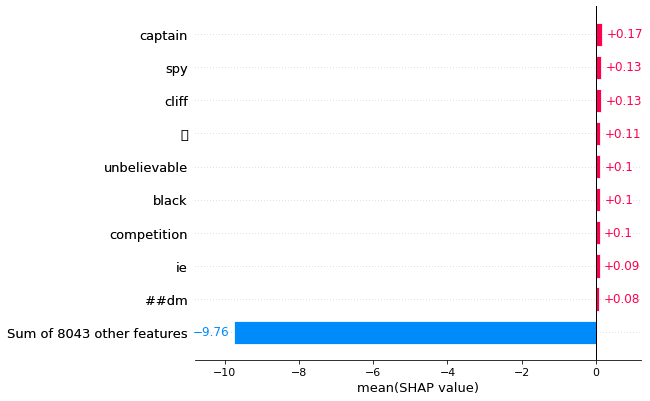

In [ ]:
shap.plots.bar(shap_values.mean(0), order=shap.Explanation.argsort.flip)

# Quantitative assessment

In [ ]:
modtxt = checkit[0]
vals = score_and_visualize(modtxt)

Prediction is => Real  p(is_fake)= [0.46252666]


In [ ]:
df = pd.DataFrame({'v':vals.values[0], 'l':vals.data[0]})
df = df.sort_values(by="v", ascending=True)
df[:1]["l"].values[0]

'but '